# Load the dataset

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import talib
import matplotlib.pyplot as plt

### Load the dataset

path_to_dataset = 'GOOG.csv'
try:
    import google.colab
    from google.colab import drive
    drive.mount('/content/drive')

    #CHANGE THIS
    colab_path = "/content/drive/MyDrive/Colab Notebooks/NTU_FinTech/"
    path_to_dataset = colab_path + path_to_dataset
    
    IN_COLAB = True
except:
    IN_COLAB = False

daily = pd.read_csv(path_to_dataset, index_col=0, parse_dates=True)
daily.index.name = 'Date'

print(daily)

             Open   High    Low  Close     Volume  Adj Close
Date                                                        
2011-01-03  14.86  15.08  14.86  15.05   94962614      15.05
2011-01-04  15.08  15.10  14.95  15.00   73253547      15.00
2011-01-05  14.95  15.20  14.95  15.17  101671667      15.17
2011-01-06  15.21  15.40  15.19  15.28   82620526      15.28
2011-01-07  15.34  15.40  15.20  15.35   84363033      15.35
...           ...    ...    ...    ...        ...        ...
2013-12-23  27.59  27.79  27.52  27.77   69122119      27.77
2013-12-24  27.77  27.78  27.60  27.69   29478078      27.69
2013-12-26  27.75  27.87  27.61  27.83   53712576      27.83
2013-12-27  27.90  27.90  27.72  27.86   63023345      27.86
2013-12-30  27.90  27.91  27.62  27.63   49629328      27.63

[753 rows x 6 columns]


# Preprocess features

In [2]:
### Preprocess features

features = ["Open", "High", "Low", "Close", "Volume", "Adj Close"]

daily_ma_10 = dict()
daily_ma_30 = dict()

for feature in features:
    daily_ma_10[feature] = talib.SMA(daily[feature], 10).to_numpy()
    daily_ma_10[feature][:9] = daily[feature][:9]   #Use dummy values (non-averaged values) to replace NANs
    
    daily_ma_30[feature] = talib.SMA(daily[feature], 30).to_numpy()
    daily_ma_30[feature][:29] = daily[feature][:29] #Use dummy values (non-averaged values) to replace NANs

K, D = talib.STOCH(daily["High"], daily["Low"], daily["Close"])
K_numpy = K.to_numpy()
D_numpy = D.to_numpy()

#Use dummy value (first non-NAN value) to replace NANs
K_numpy[:8] = K_numpy[8]
D_numpy[:8] = D_numpy[8]



# Plot dataset features

C:\Users\vital\anaconda3\envs\FinTech\lib\site-packages\mplfinance\_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


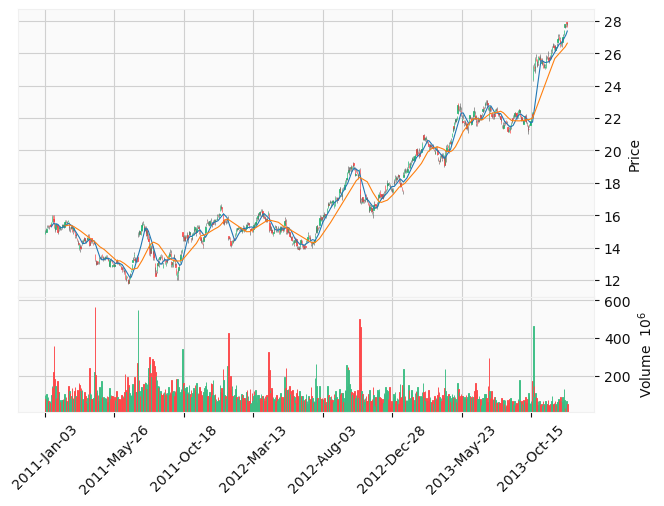

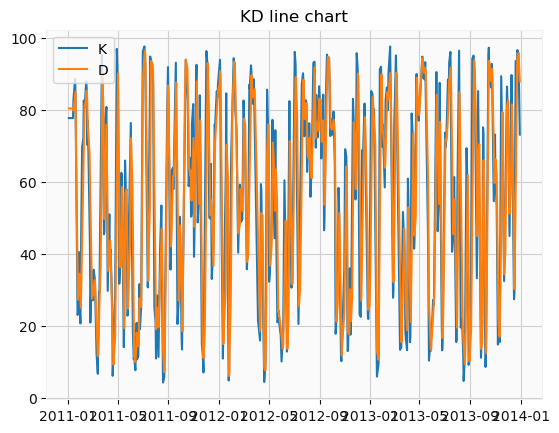

In [3]:
### (i) Plot

mpf.plot(daily["2011-01-03":"2013-12-30"], type='candle', mav=(10, 30),volume=True,style='yahoo')
plt.show()

plt.title("KD line chart")
plt.plot(K, label="K")
plt.plot(D, label="D")
plt.legend()
plt.show()

# Train, Validation, Test split and Normalization

In [4]:
### Train, Validation, Test split and Normalization

## Get sizes
train_size = len(daily["2011-01-01":"2012-12-31"])
validation_size = len(daily["2013-01-01":"2013-06-30"])
test_size = len(daily["2013-07-01":"2013-12-31"])
total = len(daily)

print("train_size: \t", train_size)
print("validation_size: \t", validation_size)
print("test_size: \t", test_size)
print("total \t", total)

print("\n")

## Split data
data = np.zeros((total, 2))
data[:-1, 0] = daily["Close"].to_numpy()[1:] # Closing value of the next day
data[-1, 0] = daily["Close"].to_numpy()[-1]

data[:, 1] = data[:, 0] - daily["Close"].to_numpy() # Closing value differential

## (ii) Add features to our dataset
for feature in features:
    data = np.concatenate((data, daily[feature].to_numpy()[:, None]), axis = 1)
    data = np.concatenate((data, daily_ma_10[feature][:, None]), axis = 1)
    data = np.concatenate((data, daily_ma_30[feature][:, None]), axis = 1)

data = np.concatenate((data, K_numpy[:, None]), axis = 1)
data = np.concatenate((data, D_numpy[:, None]), axis = 1)

X_close_idx = 9

## Split
Y1_train = data[:train_size, 0] ## Closing value of the next day
Y2_train = data[:train_size, 1] ## Differential of current and next closing value
X__train = data[:train_size, 2:]

Y1_val   = data[train_size:train_size+validation_size, 0]
Y2_val   = data[train_size:train_size+validation_size, 1]
X__val   = data[train_size:train_size+validation_size, 2:]

Y1_test  = data[train_size+validation_size:train_size+validation_size+test_size, 0]
Y2_test  = data[train_size+validation_size:train_size+validation_size+test_size, 1]
X__test  = data[train_size+validation_size:train_size+validation_size+test_size, 2:]

## (ii) Normalization
#We have to set up the scaling parameters based only on the training set, otherwise we'd be fitting our scaling parameters on the val/test set
Y1_min = np.min(Y1_train)
Y1_max = np.max(Y1_train)

Y2_mean = np.mean(Y2_train)
Y2_var  = np.std(Y2_train)

X_min  = np.min(X__train, axis = 0)
X_max  = np.max(X__train, axis = 0)

def normalize_Y1(Y1):
    return (Y1 - Y1_min) / (Y1_max - Y1_min)
def normalize_Y2(Y2): ## We want the mean to be equal to 0 and the variance to be equal to 1, so that the initial MSE of the model is close to the default one
    return (Y2 - Y2_mean) / Y2_var
def normalize_X_(X):
    return (X - X_min[None, :]) / (X_max - X_min)[None, :]

def rescale_back_Y1(Y1):
    return ((Y1 * (Y1_max - Y1_min)) + Y1_min)
def rescale_back_Y2(Y2):
    return ((Y2 * Y2_var) + Y2_mean)
    
def transform_back_Y2(Y2, X):
    X_rescaled = (X * (X_max - X_min)[None, :]) + X_min[None, :]
    Y2_rescaled = rescale_back_Y2(Y2)
    return Y2_rescaled + X_rescaled[:, X_close_idx]
    

#I consider the variance of differences in successive closing values as the "default MSE" that we should want to beat with our model
def get_default_mse(Y1, X):
    average_Y1_close_diff = np.mean(Y1 - X[:, X_close_idx])
    return np.mean((Y1 - X[:, X_close_idx] - average_Y1_close_diff) ** 2)
    
print("Original scale default train MSE: ", get_default_mse(Y1_train, X__train))
print("Original scale default val MSE: "  , get_default_mse(Y1_val, X__val))
print("Original scale default test MSE:  ", get_default_mse(Y1_test, X__test))

#Normalize the sets according to the training set parameters
Y1_train = normalize_Y1(Y1_train)
Y2_train = normalize_Y2(Y2_train)
X__train = normalize_X_(X__train)

Y1_val   = normalize_Y1(Y1_val)
Y2_val   = normalize_Y2(Y2_val)
X__val   = normalize_X_(X__val)

Y1_test  = normalize_Y1(Y1_test)
Y2_test  = normalize_Y2(Y2_test)
X__test  = normalize_X_(X__test)

# Default training MSEs
print("default_MSE1: ", get_default_mse(Y1_train, X__train))

default_MSE2 = np.mean(Y2_train ** 2)
print("default_MSE2: ", default_MSE2)

train_size: 	 502
validation_size: 	 124
test_size: 	 127
total 	 753


Original scale default train MSE:  0.060542124728178916
Original scale default val MSE:  0.05981318938605623
Original scale default test MSE:   0.11513917787835576
default_MSE1:  0.0011360879100802952
default_MSE2:  1.0


# Model building and training procedures

In [5]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import time

default_dtype = torch.float32
torch.set_default_dtype(default_dtype)

random_seed = 42
generator = np.random.RandomState(random_seed)

#Initialize PyTorch
USE_CUDA = True

cuda_available = torch.cuda.is_available()
print("Cuda available: ", cuda_available)
print("Using Cuda: ", USE_CUDA)

if cuda_available:
  print(torch.cuda.current_device())
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
  cuda_device = torch.device("cuda:0")

sequence_length = 30

## (iv), (vi), (vii) Model structure
class Recurrent_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, sequence_length, cell_type="rnn"):
        super(Recurrent_model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        if cell_type == "rnn":
            self.recurrent_cell = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == "gru":
            self.recurrent_cell = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        elif cell_type == "lstm":
            self.recurrent_cell = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        else:
            raise ValueError("ERROR::wrong recurrent cell type")
        self.fc = nn.Linear(hidden_size, 1)
        

    def forward(self, x):        
        x, _ = self.recurrent_cell(x)
        x = self.fc(x)
        return x

## Weights are initialized close to 0 and biases as 0, this way newly initialized models will be close to the default MSE, in case of Y2.
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    torch.nn.init.xavier_uniform_(layer_in.weight, gain=0.01)
    layer_in.bias.data.fill_(0.0)

## Turn data into sequences of length 30 that can be used for training
def get_batch_sequences(batch_idx, batch_size, permutation, X, Y):
    sample_sz = X.shape[0] - sequence_length

    batch_start = batch_idx * batch_size
    batch_end   = min(sample_sz, (batch_idx + 1) * batch_size)
    actual_size = batch_end - batch_start

    batch_indeces = permutation[batch_start:batch_end]
    batch_target = np.concatenate([Y[idx:idx + sequence_length][None, :, None] for idx in batch_indeces], axis=0)
    batch_data = np.concatenate([X[idx:idx + sequence_length][None, :, :] for idx in batch_indeces], axis=0)

    batch_target = torch.from_numpy(batch_target).to(dtype = default_dtype)
    batch_data = torch.from_numpy(batch_data).to(dtype = default_dtype)
    
    if USE_CUDA and cuda_available:
        batch_data = batch_data.cuda()
        batch_target = batch_target.cuda()

    return [batch_data, batch_target, actual_size]

## Training step
def train(epoch, model, optimizer, X, Y, batch_size):
    model.train()

    sample_sz = X.shape[0] - sequence_length
    perm = np.random.permutation(sample_sz)

    total_loss = 0
    
    for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
        batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)
        
        output = model(batch_data)
        loss = F.mse_loss(output, batch_target, reduction="mean")
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    total_loss /= np.ceil(sample_sz / batch_size)
    print('Epoch: {} \tTrain loss: {:.7f}'.format(epoch, total_loss), end="\r")

## Testing
def test(model, X, Y, batch_size):
    model.eval()
    test_loss = 0
    correct = 0
    
    sample_sz = X.shape[0] - sequence_length
    with torch.no_grad():
        perm = np.random.permutation(sample_sz)
        
        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y)
    
            output = model(batch_data)
            test_loss += F.mse_loss(output, batch_target, reduction="sum").item() / sequence_length

    test_loss /= sample_sz
    return test_loss

## Predicting
def predict(model, X, batch_size):
    model.eval()
    test_loss = 0
    correct = 0
    sample_sz = X.shape[0] - sequence_length

    Y_dummy = np.zeros((X.shape[0]))
    Y_hat = np.zeros((X.shape[0]))
    
    with torch.no_grad():
        perm = np.arange(0, sample_sz)
        for batch_idx in range(0, int(np.ceil(sample_sz / batch_size))):
            batch_data, batch_target, actual_size = get_batch_sequences(batch_idx, batch_size, perm, X, Y_dummy)
    
            output = model(batch_data)

            start_idx = sequence_length + batch_idx * batch_size
            end_idx = start_idx + actual_size

            ## First 30 days are predicted based only on the longest preceding sequence
            if batch_idx == 0:
                Y_hat[:sequence_length] = output[0, :, 0].cpu()
            ## Other days are predicted using the full 30day-long preceding sequence
            Y_hat[start_idx: end_idx] = output[:, -1, 0].cpu()


    return Y_hat

Cuda available:  True
Using Cuda:  True
0
1
NVIDIA GeForce RTX 3060


# Grid search procedures

In [6]:
input_size = 20 ## (iii) (batch size, time step, and input dimension) = (10 or 50, 30, 20)

## One step of a grid search
def grid_search_step(input_size, hidden_size, num_layers, epochs, lr, batch_size, predict_differential, cell_type, print_loss):
    X_train = X__train
    X_val = X__val

    Y_train = None
    Y_val = None
    if predict_differential:
        Y_train = Y2_train
        Y_val = Y2_val
    else:
        Y_train = Y1_train
        Y_val = Y1_val


    model = Recurrent_model(input_size, hidden_size, num_layers, sequence_length, cell_type=cell_type)
    
    if USE_CUDA and cuda_available:
      model = model.cuda()
    model.apply(weights_init)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    
    # Get initial performance
    test_loss = test(model, X_val, Y_val, batch_size)
    if print_loss:
        print('\nInitial: Test loss: {:.7f}\n'.format(test_loss))

    # Train
    train_losses = []
    val_losses = []
    for epoch in range(1, epochs + 1):
        train(epoch, model, optimizer, X_train, Y_train, batch_size)

        if print_loss:
            train_loss = test(model, X_train, Y_train, batch_size)
            val_loss   = test(model, X_val, Y_val, batch_size)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print('Epoch:' + str(epoch) + ' \tTrain loss: {:.7f} \tVal loss: {:.7f}\n'.format(train_loss, val_loss))
            
    final_val_loss = None
    if not print_loss:
        final_val_loss = test(model, X_val, Y_val, batch_size)
    else:
        final_val_loss = val_losses[-1]
    print("\nTime to train: {:.3f}s\t final val loss:{:.7f}".format(time.time() - start_time, final_val_loss))
    
    if print_loss:
        return [model, train_losses, val_losses]
    else:
        return [model, final_val_loss]

## (iv), (v), (vi), (vii)  Plotting loss curve and prediction
def plot_losses(model, train_losses, val_losses, predict_differential, cell_type, add_label):
    title_txt = " Predicting: value;"
    if predict_differential:
        title_txt = " Predicting: differential;"
    title_txt = add_label + title_txt + " Cell: " + cell_type
    
    X = np.concatenate((X__train, X__val, X__test))
    Y1 = np.concatenate((Y1_train, Y1_val, Y1_test))
    Y_hat = predict(model, X, 100)

    Y1 = rescale_back_Y1(Y1)
    if predict_differential:
        Y_hat = transform_back_Y2(Y_hat, X)
    else:
        Y_hat = rescale_back_Y1(Y_hat)

    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout={'pad':1}, figsize=(10, 5))
    
    plt.title(title_txt)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(val_losses, label="val loss")
    plt.xlabel("epochs")
    plt.ylabel("MSE")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Y_hat, label="Predicted")
    plt.plot(data[:, 0], label="Ground truth")
    plt.legend()
    plt.xlabel("day")
    plt.ylabel("Stock value")
    plt.show()

    SE = (Y1 - Y_hat) ** 2
    print("Original scale MSE:")
    print("\t Train MSE:", np.mean(SE[:train_size]))
    print("\t Val   MSE:", np.mean(SE[train_size:train_size+validation_size]))
    print("\t Test  MSE:", np.mean(SE[train_size+validation_size:train_size+validation_size+test_size]))


def grid_search(predict_differential, cell_type):
    epochs = 200
    lrs = [0.000001, 0.000005, 0.00003, 0.0003]
    batch_sizes = [10, 50]

    hidden_sizes = [10, 50, 100]
    layers = [1, 2]

    best_lr = 0
    best_batch_size = 0
    best_layer = 0
    best_hidden_size = 0
    
    best_val_loss = float("inf")
    

    for lr in lrs:
        for batch_size in batch_sizes:
            for layer in layers:
                for hidden_size in hidden_sizes:
                    print("***lr: " + str(lr), "batch_size: " + str(batch_size), "layer: " + str(layer), "hidden_size: " + str(hidden_size))
                    model, val_loss = grid_search_step(input_size, hidden_size, layer, epochs, lr, batch_size, predict_differential = predict_differential, cell_type=cell_type, print_loss=False)
                    if best_val_loss > val_loss:
                        print("New best!")
                        best_lr = lr
                        best_batch_size = batch_size
                        best_layer = layer
                        best_hidden_size = hidden_size
                    
                        best_val_loss = val_loss

    print("Best validation loss: ", best_val_loss)
    model, train_losses, val_losses = grid_search_step(input_size, best_hidden_size, best_layer, epochs, best_lr, best_batch_size, predict_differential = predict_differential, cell_type=cell_type, print_loss=True)
    return [model, train_losses, val_losses]


# Performing grid search for each model type

In [7]:
### (iv)  Using RNN
model_dif_rnn, train_losses_dif_rnn, val_losses_dif_rnn = grid_search(True,  "rnn")
model_rnn,     train_losses_rnn,     val_losses_rnn = grid_search(False, "rnn")

### (vi)  Using GRU
model_dif_gru, train_losses_dif_gru, val_losses_dif_gru = grid_search(True,  "gru")
model_gru,     train_losses_gru,     val_losses_gru = grid_search(False, "gru")

### (vii) Using LSTM
model_dif_lstm, train_losses_dif_lstm, val_losses_dif_lstm = grid_search(True,  "lstm")
model_lstm,     train_losses_lstm,     val_losses_lstm = grid_search(False, "lstm")

***lr: 1e-06 batch_size: 10 layer: 1 hidden_size: 10
Epoch: 200 	Train loss: 1.0272758
Time to train: 22.365s	 final val loss:1.0366901
New best!
***lr: 1e-06 batch_size: 10 layer: 1 hidden_size: 50
Epoch: 200 	Train loss: 1.0151392
Time to train: 15.828s	 final val loss:1.1254162
***lr: 1e-06 batch_size: 10 layer: 1 hidden_size: 100
Epoch: 200 	Train loss: 1.0282664
Time to train: 14.192s	 final val loss:1.1656495
***lr: 1e-06 batch_size: 10 layer: 2 hidden_size: 10
Epoch: 200 	Train loss: 1.0317531
Time to train: 16.956s	 final val loss:1.0382778
***lr: 1e-06 batch_size: 10 layer: 2 hidden_size: 50
Epoch: 200 	Train loss: 1.0216602
Time to train: 15.679s	 final val loss:1.0762423
***lr: 1e-06 batch_size: 10 layer: 2 hidden_size: 100
Epoch: 200 	Train loss: 1.0041921
Time to train: 27.328s	 final val loss:1.1141893
***lr: 1e-06 batch_size: 50 layer: 1 hidden_size: 10
Epoch: 200 	Train loss: 1.0202474
Time to train: 2.964s	 final val loss:1.0263776
New best!
***lr: 1e-06 batch_size: 50

# Plotting results

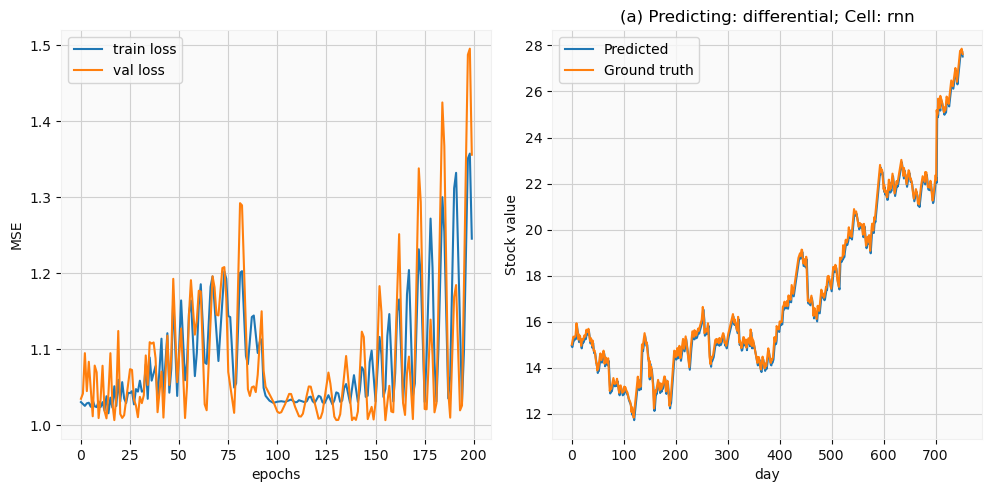

Original scale MSE:
	 Train MSE: 0.07396856155142105
	 Val   MSE: 0.0802738038454047
	 Test  MSE: 0.13868321249535026


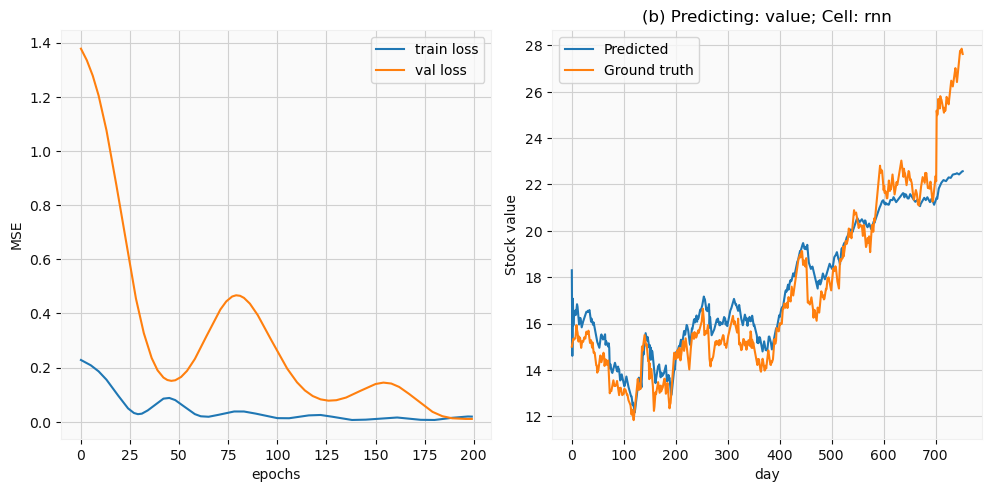

Original scale MSE:
	 Train MSE: 0.8011374494000405
	 Val   MSE: 0.4038199088323117
	 Test  MSE: 6.709510471771427



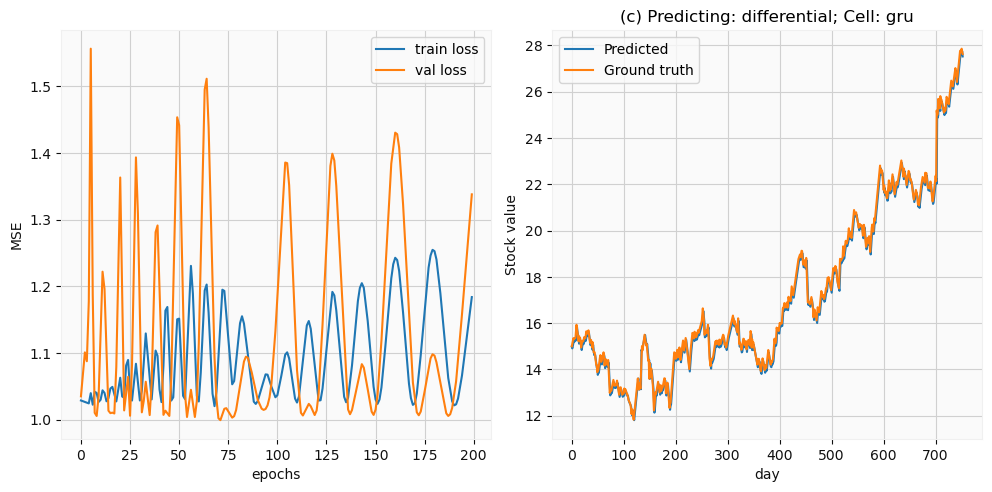

Original scale MSE:
	 Train MSE: 0.07161368787885124
	 Val   MSE: 0.0801809992437293
	 Test  MSE: 0.13790190418319045


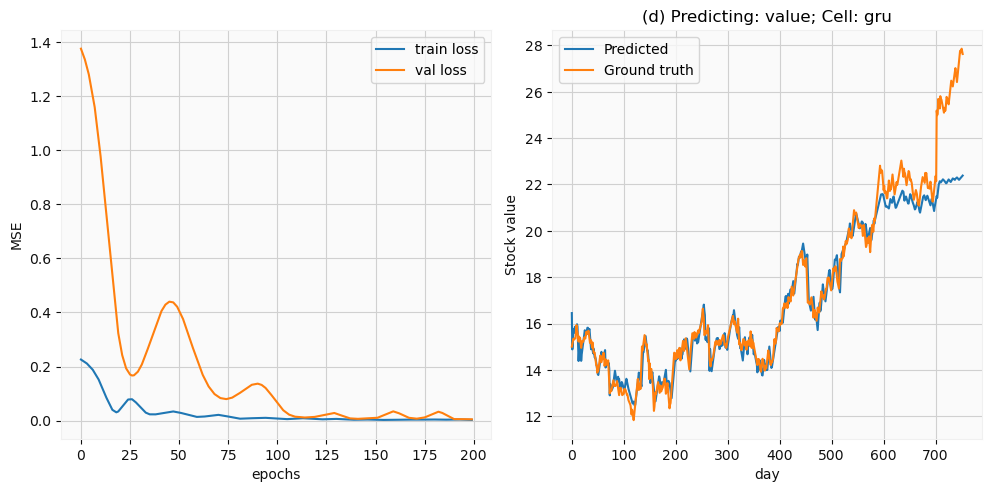

Original scale MSE:
	 Train MSE: 0.1598775596924936
	 Val   MSE: 0.3052083246293511
	 Test  MSE: 7.071339872252426



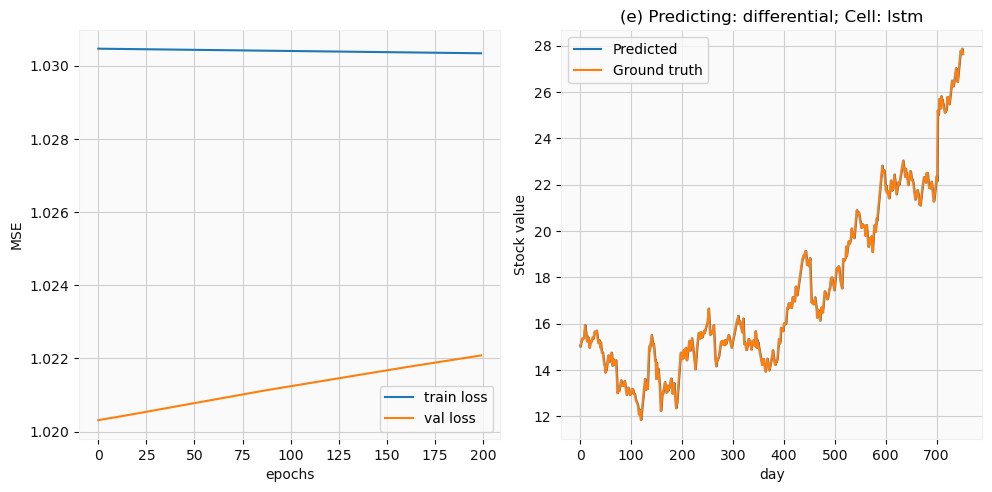

Original scale MSE:
	 Train MSE: 0.06054234795492322
	 Val   MSE: 0.060626439260513657
	 Test  MSE: 0.11665595151644563


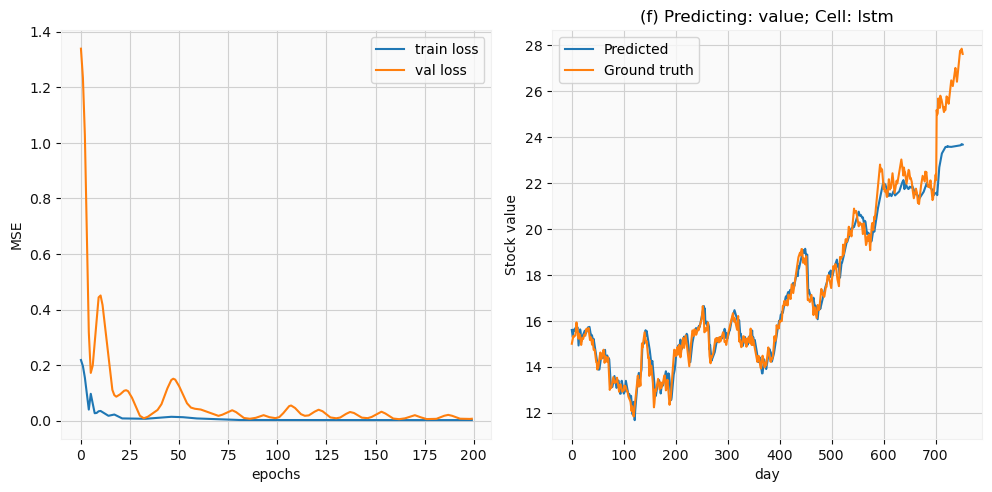

Original scale MSE:
	 Train MSE: 0.15083501727417595
	 Val   MSE: 0.23623676154762288
	 Test  MSE: 3.5151660524992923


In [8]:
## (iv), (v), (vi), (vii)  Plotting loss curve and prediction

plot_losses(model_dif_rnn, train_losses_dif_rnn, val_losses_dif_rnn, True, "rnn", "(a)")
plot_losses(model_rnn, train_losses_rnn, val_losses_rnn, False, "rnn", "(b)")

print("")
plot_losses(model_dif_gru, train_losses_dif_gru, val_losses_dif_gru, True,  "gru", "(c)")
plot_losses(    model_gru,     train_losses_gru,     val_losses_gru, False, "gru", "(d)")

print("")
plot_losses(model_dif_lstm, train_losses_dif_lstm, val_losses_dif_lstm, True,  "lstm", "(e)")
plot_losses(    model_lstm,     train_losses_lstm,     val_losses_lstm, False, "lstm", "(f)")